## current state

The model currently runs correctly and robustly (no errors for any inputs), but certain variables/formulas are still not 100%. These include

variables:
- drainage for the basin (line 31). Dependent on size of the drainage channels, which changes based on the amount of rain.
- infiltration in basin (in classes file). currently set to 2.5, which is quite low for the soil type present.
- exact shape of the tide and storm surge (almost good, just needs final check)

formulas:
- Open channel flow (in calculations). Looks like a modified manning equation
- formula broad weir. Should be checked and reported upon further

general:
- rainfall is modeled as a constant currently, this could potentially be oversimplified.
- assumptions in the shape of the storm surge should also be checked.

## Get packages ready

In [1]:
import sys
sys.path.append('./Packages')
%pwd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import pandas as pd
from __future__ import (absolute_import, division, print_function, unicode_literals)

import Classes as Load_Data
from calculations import calculate_inflow_rain, calculate_storm_surge, calculate_infiltration, calculate_interbasin, calculation_drainage


## Load in data

In [2]:
hydraulic=Load_Data.load_hydraulic_conditions('FLORES input/surge_Helensville.csv', 'FLORES input/rainfall_Helensville.csv', timestep=0.1)
basin_master = Load_Data.load_basins('FLORES input/lidar_basins_sort.csv')
layer_master = Load_Data.load_layers('FLORES input/LOD_Xan.csv', basin_master)
Load_Data.load_drainage_capacities(basin_master, 'FLORES input/lidar_baisin_drainage.csv', 30000, 50000, 90000, 5, 10, 15)
Load_Data.load_basin_borders(basin_master, 'FLORES input/lidar_basin_borders_no0.csv')

## Setting up the boundary conditions for this run
To model a run, all that is necessary is to change the value for k

In [3]:
k='100,100'                                                                 #return period for [rainfall, storm]
storm_duration          = hydraulic[k].StormDuration                             # [hours]
# rain_intensity          = hydraulic['2,50'].MaxRainIntensity

mean_sea_level          = hydraulic[k].MeanSeaLevel       #[m]

#General
timestep                = 0.1                              #[hours]
time                    = np.arange(0,storm_duration,timestep)     #Easy calculation to get a calculation for each timestep
rain_series             = Load_Data.pad_or_truncate(hydraulic[k].RainSeries, len(time))      # [mm/hour] pad or truncate makes list length same as another variable
outside_waterlevel      = Load_Data.pad_or_truncate(hydraulic[k].SurgeSeries, len(time))     #[m]



## Setting up necessary dicts for the run
here first empty dicts are started, which are then filled for each basin in the next cell

In [4]:
#General
Volume              = {}
basin_water_level   = {}
retention           = {}
abs_surrounding_wl  = {}
abs_basin_wl        = {}
drain_to_water_level_abs = {}

#Different inflows
inflow_volume_rain  = {}
inflow_storm_surge  = {}
inflow_drainage     = {}
inflow_neighbors    = {}
#Different outflows
outflow_infiltrate  = {}
outflow_drainage    = {}
outflow_retention   = {}
outflow_neighbors = {}


In [5]:
for basin in basin_master:
    Volume[basin]               = [0]*(len(time)+1)
    basin_water_level[basin]    = [0]*(len(time)+1)
    retention[basin]            = [0]*(len(time)+1)
    abs_surrounding_wl[basin]   = {}
    abs_basin_wl[basin]         = [basin_master[basin].Contours[0].MinHeight]*len(time)
    drain_to_water_level_abs[basin]= [0]*(len(time)+1)

    inflow_volume_rain[basin]   = [0]*len(time)
    inflow_storm_surge[basin]   = [0]*len(time)
    inflow_drainage[basin]      = [0]*(len(time)+1)
    inflow_neighbors[basin]     = [0]*(len(time)+1)

    outflow_infiltrate[basin]   = [0]*len(time)
    outflow_drainage[basin]     = [0]*len(time)
    outflow_retention[basin]    = [0]*len(time)
    outflow_neighbors[basin]    = [0]*len(time)




## Main calculation
here the main calculation takes place. This will be made a bit more lean in next steps.

In [6]:
for i in range(len(time)):
    for basin in basin_master:

    #Set some variables
        # basin_water_level[basin][i] = float(basin_master[basin].VolumeToHeight(Volume[basin][i]) - basin_master[basin].Contours[0].MinHeight)
        abs_basin_wl[basin][i] = float(basin_master[basin].VolumeToHeight(Volume[basin][i]))
        basin_water_level[basin][i] = abs_basin_wl[basin][i] - basin_master[basin].Contours[0].MinHeight


        abs_surrounding_wl[basin][i]=Load_Data.get_absolute_surrounding_water_levels(basin_master[basin], i, abs_basin_wl)

        drainage = int(basin_master[basin].DrainsToBasin)
        if drainage != 0:
            drain_to_water_level_abs[basin][i]    = abs_basin_wl[drainage][i]
        else:
            drain_to_water_level_abs[basin][i]    = outside_waterlevel[i]


    #INFLOWS
        inflow_volume_rain[basin][i] = calculate_inflow_rain(basin_master[basin], rain_series[i], timestep)

        for sequence in layer_master:
            if layer_master[sequence].Type == 'Line of Defense':
                for location in layer_master[sequence].FDLocations:
                    if basin in layer_master[sequence].FDLocations[location].BasinCodesWidths:
                        inflow_storm_surge[basin][i] =  calculate_storm_surge(basin_master[basin], abs_basin_wl[basin][i], layer_master[sequence].FDLocations[location], outside_waterlevel[i], timestep)


        outflow_retention[basin][i] = min(Volume[basin][i], basin_master[basin].RetentionCapacity - retention[basin][i])

        retention[basin][i] += outflow_retention[basin][i]

        [outflow_drainage[basin][i], r]  = calculation_drainage(basin_master[basin], Volume[basin][i], timestep, drain_to_water_level_abs[basin][i], abs_basin_wl[basin][i], retention[basin][i])

        if drainage != 0:
            inflow_drainage[drainage][i+1] = float(outflow_drainage[basin][i])

        retention[basin][i+1] = r

    #OUTFLOWS
        outflow_infiltrate[basin][i] = calculate_infiltration(basin_master[basin], timestep, abs_basin_wl[basin][i])


        f = calculate_interbasin(basin_master[basin], abs_basin_wl[basin][i], abs_surrounding_wl[basin][i])



        outflow_neighbors[basin][i]= sum(f.values())

        for b in f:
            inflow_neighbors[b][i+1] = f[b]



    #Hydrological balance (van Berchum et al. 2020)
        Volume[basin][i+1] =  max(0, Volume[basin][i] + (inflow_volume_rain[basin][i] + inflow_storm_surge[basin][i] + inflow_drainage[basin][i] + inflow_neighbors[basin][i]
                                                 - outflow_infiltrate[basin][i] - outflow_retention[basin][i] -outflow_neighbors[basin][i] - outflow_drainage[basin][i] ))





## various plots
In the next part a start has been made in exploring the results

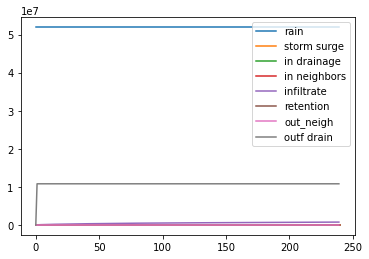

In [7]:
b = 5

plt.plot(inflow_volume_rain[b], label='rain')
plt.plot(inflow_storm_surge[b], label = 'storm surge')
plt.plot(inflow_drainage[b], label = 'in drainage')
plt.plot(inflow_neighbors[b], label = 'in neighbors')
plt.plot(outflow_infiltrate[b], label = 'infiltrate')
plt.plot(outflow_retention[b], label = 'retention')
plt.plot(outflow_neighbors[b], label = 'out_neigh')
plt.plot(outflow_drainage[b], label = 'outf drain')
plt.legend()

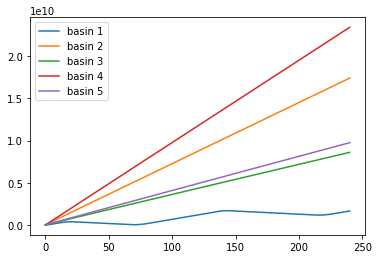

In [8]:
plt.plot(Volume[1], label='basin 1')
plt.plot(Volume[2], label='basin 2')
plt.plot(Volume[3], label='basin 3')
plt.plot(Volume[4], label='basin 4')
plt.plot(Volume[5], label='basin 5')
plt.legend()


In [9]:
x=(min(basin_master[1].Area, basin_master[2].Area, basin_master[3].Area, basin_master[4].Area, basin_master[5].Area))

print('area basin 1', basin_master[1].Area, basin_master[1].Area/x)
print('area basin 2', basin_master[2].Area, basin_master[2].Area/x)
print('area basin 3', basin_master[3].Area, basin_master[3].Area/x)
print('area basin 4', basin_master[4].Area, basin_master[4].Area/x)
print('area basin 5', basin_master[5].Area, basin_master[5].Area/x)


area basin 1 9070139484.579998 1.0
area basin 2 113958683762.53004 12.564160006168528
area basin 3 68315675617.70001 7.531932197276836
area basin 4 131773905746.26996 14.528321859911495
area basin 5 64889141562.93001 7.154150349423735


In [10]:
# plt.plot(outflow_retention[1], label='basin 1')
# plt.plot(outflow_retention[2], label='basin 2')
# plt.plot(outflow_retention[3], label='basin 3')
# plt.plot(outflow_retention[4], label='basin 4')
# plt.plot(outflow_retention[5], label='basin 5')
# plt.legend()

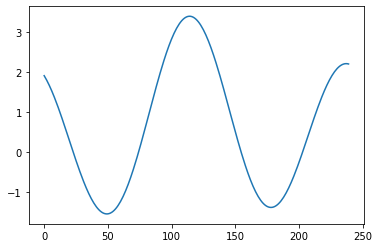

In [11]:
plt.plot(outside_waterlevel)

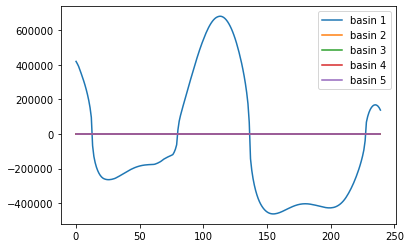

In [12]:
plt.plot(inflow_storm_surge[1], label='basin 1')
plt.plot(inflow_storm_surge[2], label='basin 2')
plt.plot(inflow_storm_surge[3], label='basin 3')
plt.plot(inflow_storm_surge[4], label='basin 4')
plt.plot(inflow_storm_surge[5], label='basin 5')
plt.legend()

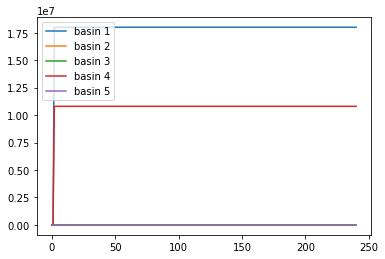

In [13]:
plt.plot(inflow_drainage[1], label='basin 1')
plt.plot(inflow_drainage[2], label='basin 2')
plt.plot(inflow_drainage[3], label='basin 3')
plt.plot(inflow_drainage[4], label='basin 4')
plt.plot(inflow_drainage[5], label='basin 5')
plt.legend()

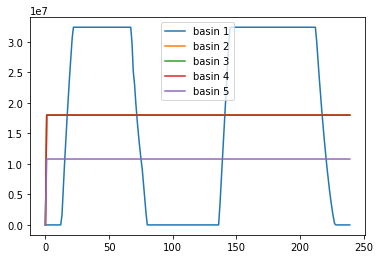

In [14]:
plt.plot(outflow_drainage[1], label='basin 1')
plt.plot(outflow_drainage[2], label='basin 2')
plt.plot(outflow_drainage[3], label='basin 3')
plt.plot(outflow_drainage[4], label='basin 4')
plt.plot(outflow_drainage[5], label='basin 5')
plt.legend()

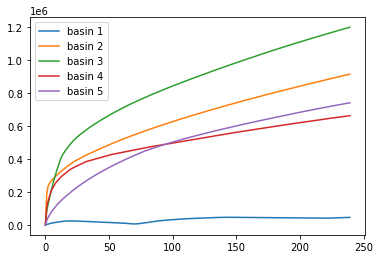

In [15]:
plt.plot(outflow_infiltrate[1], label='basin 1')
plt.plot(outflow_infiltrate[2], label='basin 2')
plt.plot(outflow_infiltrate[3], label='basin 3')
plt.plot(outflow_infiltrate[4], label='basin 4')
plt.plot(outflow_infiltrate[5], label='basin 5')
plt.legend()

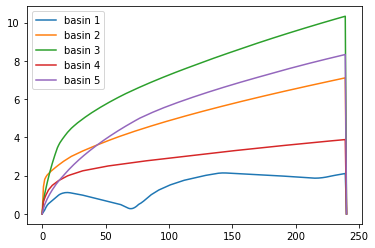

In [16]:
plt.plot(basin_water_level[1], label='basin 1')
plt.plot(basin_water_level[2], label='basin 2')
plt.plot(basin_water_level[3], label='basin 3')
plt.plot(basin_water_level[4], label='basin 4')
plt.plot(basin_water_level[5], label='basin 5')
plt.legend()

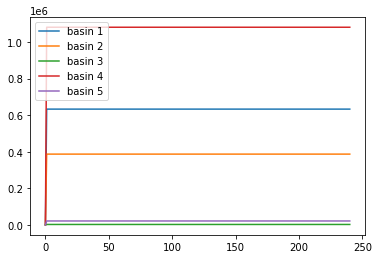

In [17]:
plt.plot(retention[1], label='basin 1')
plt.plot(retention[2], label='basin 2')
plt.plot(retention[3], label='basin 3')
plt.plot(retention[4], label='basin 4')
plt.plot(retention[5], label='basin 5')
plt.legend()

In [18]:
# basin_master = basin_master
# Basin = basin_master[3]
# surrounding_water_levels=Load_Data.get_absolute_surrounding_water_levels(Basin, 200, abs_basin_wl)
#
#
#
# flow_to_other_basins = {}
# surrounding_thresholds = {b: max(surrounding_water_levels[b], Basin.BorderHeights[b]) for b in
#                           surrounding_water_levels.keys()}
#
#
#
# sorted_thresholds = sorted(surrounding_thresholds.items(), key=lambda kv: kv[1])
# basin_numbers_sorted = []
# surrounding_basins_threshold = []
# surface_areas_sorted = []
# for i in range(len(sorted_thresholds)):
#     basin_numbers_sorted.append(sorted_thresholds[i][0])
#     surrounding_basins_threshold.append(sorted_thresholds[i][1])
#     surface_areas_sorted.append(Basin.SurroundingAreas[sorted_thresholds[i][0]])
#
# new_absolute_water_level = basin_water_level
# for j in range(len(surrounding_basins_threshold)):
#     tmp_absolute_water_level = new_absolute_water_level
#     if tmp_absolute_water_level > surrounding_basins_threshold[j]:
#         area_factor = Basin.Area / surface_areas_sorted[j]
#         new_absolute_water_level = (tmp_absolute_water_level * area_factor + surrounding_basins_threshold[j]) / (1 + area_factor)
#         print(new_absolute_water_level)
#         flow_to_other_basins[basin_numbers_sorted[j]] = Basin.HeightToVolume(tmp_absolute_water_level) - Basin.HeightToVolume(new_absolute_water_level)
#     #     print(area_factor)
#     #     print(new_absolute_water_level)
#     #
#     # else:
#     #     flow_to_other_basins[basin_numbers_sorted[j]] = 0
#
#  #This can be done without missing a threshold because they've already been sorted
#
# print(area_factor)